In [1]:
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
import sys 
sys.path.append('..')
from models import get_net
net = get_net("WILDCAM")

irm_model = net(n_classes=2)
print("loading IRM model")
irm_model.load_state_dict(torch.load("../models/wildcam_denoised_121_0.001_40_10000.0_IRM.pth", map_location="cpu"))
irm_model.to("cpu")

erm_model = net(n_classes=2)
print("loading ERM model")
erm_model.load_state_dict(torch.load("../models/wildcam_denoised_121_0.001_0_0.0_ERM.pth", map_location="cpu"))
erm_model.to("cpu")

loading IRM model
loading ERM model


resnet18_extractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [3]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [4]:
def batch_predict(images):
    clf.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    clf.to(device)
    batch = batch.to(device)
    
    logits = clf(batch)
    #probs = torch.sigmoid(logits)
    #probs = 1-torch.sigmoid(logits)
    probs = torch.cat((1-torch.sigmoid(logits), torch.sigmoid(logits)), 1)
    return probs.detach().cpu().numpy()[0]

In [5]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

For coyotes

In [6]:
images = os.listdir("../../../../data/wildcam_subset_denoised/test/coyote")
clf = irm_model
irm_pred = []
coyote_images = []
path = "../../../../data/wildcam_subset_denoised/test/coyote"
for img in images:
    if img.endswith(".jpg"):
        coyote_images.append(img)
        img = get_image(os.path.join(path, img))
        irm_pred.append(batch_predict([pill_transf(img)])[0])

In [7]:
np.sort(irm_pred)

array([0.21107161, 0.26566422, 0.2716428 , 0.27602106, 0.27679217,
       0.28357244, 0.28971434, 0.29158753, 0.29234493, 0.29326707,
       0.2969876 , 0.30411446, 0.31301528, 0.31332427, 0.31380236,
       0.31928122, 0.31939816, 0.32277417, 0.32355213, 0.32508695,
       0.3264532 , 0.33359194, 0.33703178, 0.33907646, 0.3393411 ,
       0.34004933, 0.34353364, 0.34415585, 0.35066825, 0.3532946 ,
       0.35349894, 0.35418165, 0.35783172, 0.36497664, 0.3669653 ,
       0.38139826, 0.3860426 , 0.3948984 , 0.39883482, 0.40150368,
       0.41128832, 0.41208768, 0.4136004 , 0.41945302, 0.4278037 ,
       0.44538248, 0.4493389 , 0.45109123, 0.45439512, 0.4609956 ,
       0.464503  , 0.4652462 , 0.46676677, 0.4753704 , 0.4790864 ,
       0.48415142, 0.49428302, 0.49509192, 0.500224  , 0.50068545,
       0.5070841 , 0.51034725, 0.51857424, 0.5267174 , 0.544443  ,
       0.5566057 , 0.5653125 , 0.57604927, 0.5782432 , 0.6064425 ,
       0.6256013 , 0.6707926 , 0.6824329 , 0.6843289 , 0.68663

In [8]:
np.argsort(irm_pred)[-20:]

array([ 56,  61,  59,  40, 109, 117,  38,  13, 136, 129,  34,  77,  49,
       137, 124, 122,  52, 108, 101, 132])

In [9]:
np.argsort(irm_pred)[-30:]

array([ 94,  16,  18,  21,  63,  83,  69, 115,  26,  57,  56,  61,  59,
        40, 109, 117,  38,  13, 136, 129,  34,  77,  49, 137, 124, 122,
        52, 108, 101, 132])

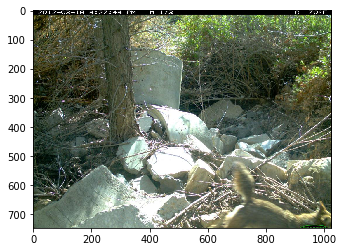

In [10]:
img = get_image(os.path.join(path, coyote_images[83]))
plt.imshow(img)

In [11]:
batch_predict([pill_transf(img)])

array([0.9677943 , 0.03220569], dtype=float32)

In [12]:
coyote_images[83]

'5865e36a-23d2-11e8-a6a3-ec086b02610b.jpg'

In [13]:
images = os.listdir("../../../../data/wildcam_subset_denoised/test/coyote")
clf = erm_model
erm_pred = []
coyote_images = []
path = "../../../../data/wildcam_subset_denoised/test/coyote"
for img in images:
    if img.endswith(".jpg"):
        coyote_images.append(img)
        img = get_image(os.path.join(path, img))
        erm_pred.append(batch_predict([pill_transf(img)])[0])

In [14]:
np.sort(erm_pred)

array([0.45160466, 0.45855272, 0.46881568, 0.47659254, 0.48321366,
       0.50906825, 0.51259136, 0.51473   , 0.5217223 , 0.5265603 ,
       0.5289072 , 0.53727746, 0.53807366, 0.538465  , 0.53951234,
       0.54923975, 0.55676675, 0.5591961 , 0.5663522 , 0.5670476 ,
       0.576558  , 0.58381414, 0.58389676, 0.58636606, 0.5872819 ,
       0.59087634, 0.5929915 , 0.60652936, 0.60790265, 0.612837  ,
       0.6132349 , 0.61426795, 0.62270534, 0.62966573, 0.6385306 ,
       0.6423712 , 0.64401615, 0.6457661 , 0.6466038 , 0.649796  ,
       0.650862  , 0.6696114 , 0.67126423, 0.6731534 , 0.6964699 ,
       0.70416677, 0.71256876, 0.71685445, 0.71716726, 0.71741855,
       0.71880245, 0.72128016, 0.7236801 , 0.72847486, 0.73449934,
       0.73459005, 0.7409426 , 0.7482263 , 0.7499798 , 0.75765014,
       0.7623864 , 0.7705141 , 0.77284104, 0.77444017, 0.7760891 ,
       0.7764666 , 0.7892195 , 0.7927576 , 0.80868596, 0.8519874 ,
       0.8652781 , 0.8671676 , 0.8827263 , 0.88852614, 0.88964

In [15]:
np.argsort(erm_pred)[-20:]

array([ 40,  26,  13,  49,  59, 124, 129,  38,  56, 109, 115,  57, 136,
       122,  52,  77, 137, 108, 132, 101])

For raccoons

In [16]:
images = os.listdir("../../../../data/wildcam_subset_denoised/test/raccoon")
clf = irm_model
irm_pred = []

raccoon_images = []
path = "../../../../data/wildcam_subset_denoised/test/raccoon"
for img in images:
    if img.endswith(".jpg"):
        raccoon_images.append(img)
        img = get_image(os.path.join(path, img))
        irm_pred.append(batch_predict([pill_transf(img)])[1])

In [17]:
np.sort(irm_pred)

array([0.337348  , 0.34028512, 0.34433308, 0.35012347, 0.3520454 ,
       0.36076012, 0.36164907, 0.36262992, 0.3707674 , 0.38691664,
       0.38837954, 0.39318728, 0.40889847, 0.40942577, 0.41312334,
       0.41369998, 0.41456208, 0.4236706 , 0.4253072 , 0.42550975,
       0.42869326, 0.4305511 , 0.43145365, 0.43276384, 0.43611658,
       0.4368204 , 0.43833065, 0.43875584, 0.44215003, 0.44430175,
       0.4450805 , 0.4472816 , 0.44751722, 0.4480375 , 0.4496073 ,
       0.45131326, 0.45131752, 0.452022  , 0.45299244, 0.45310175,
       0.45321348, 0.4539847 , 0.45415697, 0.45532355, 0.45663103,
       0.4570268 , 0.46024382, 0.46144772, 0.4615071 , 0.46283635,
       0.46308434, 0.46331105, 0.46334034, 0.46483627, 0.4666596 ,
       0.46699944, 0.4674489 , 0.4683299 , 0.4686391 , 0.4689524 ,
       0.4689702 , 0.46913266, 0.46942544, 0.46984336, 0.47028536,
       0.47031844, 0.47058824, 0.47124958, 0.47142896, 0.47216558,
       0.47401214, 0.4752186 , 0.4754166 , 0.47548395, 0.47564

In [18]:
np.argsort(irm_pred)[-30:]

array([151,  84, 222,  76,  89,  45, 141, 345, 207, 314,  61, 289, 252,
       336, 132, 321, 303, 251,  74, 211, 193, 249, 279, 282, 262,   5,
       308, 225, 274,  18])

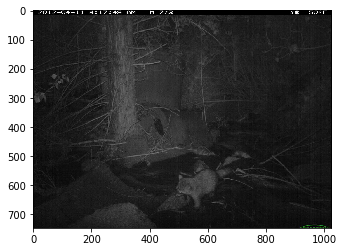

In [41]:
img = get_image(os.path.join(path, raccoon_images[61]))
plt.imshow(img)

In [42]:
clf = irm_model
batch_predict([pill_transf(img)])[1]

0.68857557

In [44]:
raccoon_images[61]

'58e2820f-23d2-11e8-a6a3-ec086b02610b.jpg'

In [22]:
images = os.listdir("../../../../data/wildcam_subset_denoised/test/raccoon")
clf = erm_model
erm_pred = []

raccoon_images = []
path = "../../../../data/wildcam_subset_denoised/test/raccoon"
for img in images:
    if img.endswith(".jpg"):
        raccoon_images.append(img)
        img = get_image(os.path.join(path, img))
        erm_pred.append(batch_predict([pill_transf(img)])[1])

In [23]:
np.sort(erm_pred)

array([0.11610316, 0.12119512, 0.1347679 , 0.13670468, 0.14011411,
       0.14594765, 0.15022086, 0.15533128, 0.15981212, 0.166499  ,
       0.16661684, 0.16781121, 0.16804464, 0.16988641, 0.17027904,
       0.17098425, 0.17581111, 0.17620808, 0.17651196, 0.17703313,
       0.18197615, 0.18244497, 0.18347944, 0.18787584, 0.18839939,
       0.18873867, 0.19036011, 0.19313776, 0.1975709 , 0.19771877,
       0.19776507, 0.1987783 , 0.19945212, 0.19946785, 0.20128432,
       0.20258091, 0.2036338 , 0.20415714, 0.20437185, 0.20725635,
       0.20786616, 0.20796005, 0.20853129, 0.20867695, 0.21111864,
       0.21539424, 0.21553898, 0.21843031, 0.22004156, 0.22004488,
       0.22057083, 0.22066733, 0.22157247, 0.221916  , 0.22282767,
       0.22351876, 0.2263779 , 0.22651097, 0.2285824 , 0.22960533,
       0.23172152, 0.23326856, 0.23395097, 0.23406048, 0.23418422,
       0.23432484, 0.23436946, 0.23566021, 0.23632763, 0.2375621 ,
       0.23872377, 0.23901658, 0.23902188, 0.24002935, 0.24091

In [24]:
np.argsort(erm_pred)[-20:]

array([303, 364, 160, 262, 279, 301, 274, 221, 225, 151, 308,  61,  45,
       282, 207, 191,  18,   5, 249, 132])